# Churn Prediction com Random Forest

## Imports

In [1]:
import kagglehub
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc
)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Configura√ß√£o visual
sns.set(style="whitegrid")

## Baixando e carregando o dataset

In [2]:
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
df = pd.read_csv('../data/processed/telco-customer-churn.csv')

## An√°lise Explorat√≥ria (EDA)

### Visualizando o in√≠cio do dataset

In [3]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

### Colunas dispon√≠veis

In [4]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

### Dimens√µes do dataset

In [5]:
df.shape

(7043, 21)

### Tipos de dados

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Estat√≠sticas descritivas (num√©ricas)

In [7]:
df.describe()

SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

### Estat√≠sticas descritivas (categ√≥ricas)

In [8]:
df.describe(include="object")

customerID gender Partner Dependents PhoneService MultipleLines  \
count         7043   7043    7043       7043         7043          7043   
unique        7043      2       2          2            2             3   
top     3186-AJIEK   Male      No         No          Yes            No   
freq             1   3555    3641       4933         6361          3390   

       InternetService OnlineSecurity OnlineBackup DeviceProtection  \
count             7043           7043         7043             7043   
unique               3              3            3                3   
top        Fiber optic             No           No               No   
freq              3096           3498         3088             3095   

       TechSupport StreamingTV StreamingMovies        Contract  \
count         7043        7043            7043            7043   
unique           3           3               3               3   
top             No          No              No  Month-to-month   
freq          3473        2810            2785            3875   

       PaperlessBilling     PaymentMethod TotalCharges Churn  
count              7043              7043         7043  7043  
unique                2                 4         6531     2  
top                 Yes  Electronic check                 No  
freq               4171              2365           11  5174

### Distribui√ß√£o de Churn

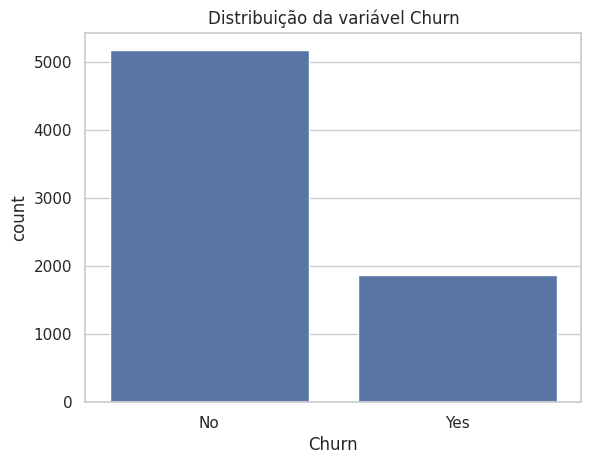

In [9]:
sns.countplot(data=df, x="Churn")
plt.title("Distribui√ß√£o da vari√°vel Churn")
plt.show()

## Pr√©-Processamento

### Convers√£o de vari√°veis categ√≥ricas para num√©ricas

In [10]:
def convert_categorical_number(df):
    df_filter = df.copy()
    df_filter = df_filter[df_filter.columns[1:]]  # Remover ID
    columns_object = df_filter.select_dtypes(include=("object")).columns

    for col in columns_object:
        _dict = {v: k for k, v in pd.DataFrame(df[col].unique()).to_dict()[0].items()}
        df_filter[col] = df_filter[col].map(_dict)

    return df_filter

df_numerical = convert_categorical_number(df)
df_numerical.head()

gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        0           0       1             0   
1       1              0        1           0      34             1   
2       1              0        1           0       2             1   
3       1              0        1           0      45             0   
4       0              0        1           0       2             1   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0              0                0               0             0   
1              1                0               1             1   
2              1                0               1             0   
3              0                0               1             1   
4              1                1               0             1   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0                0         0   
1                 1            0            0                0         1   
2                 0            0            0                0         0   
3                 1            1            0                0         1   
4                 0            0            0                0         0   

   PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  Churn  
0                 0              0           29.85             0      0  
1                 1              1           56.95             1      0  
2                 0              1           53.85             2      1  
3                 1              2           42.30             3      0  
4                 0              0           70.70             4      1

### Heatmap de correla√ß√£o

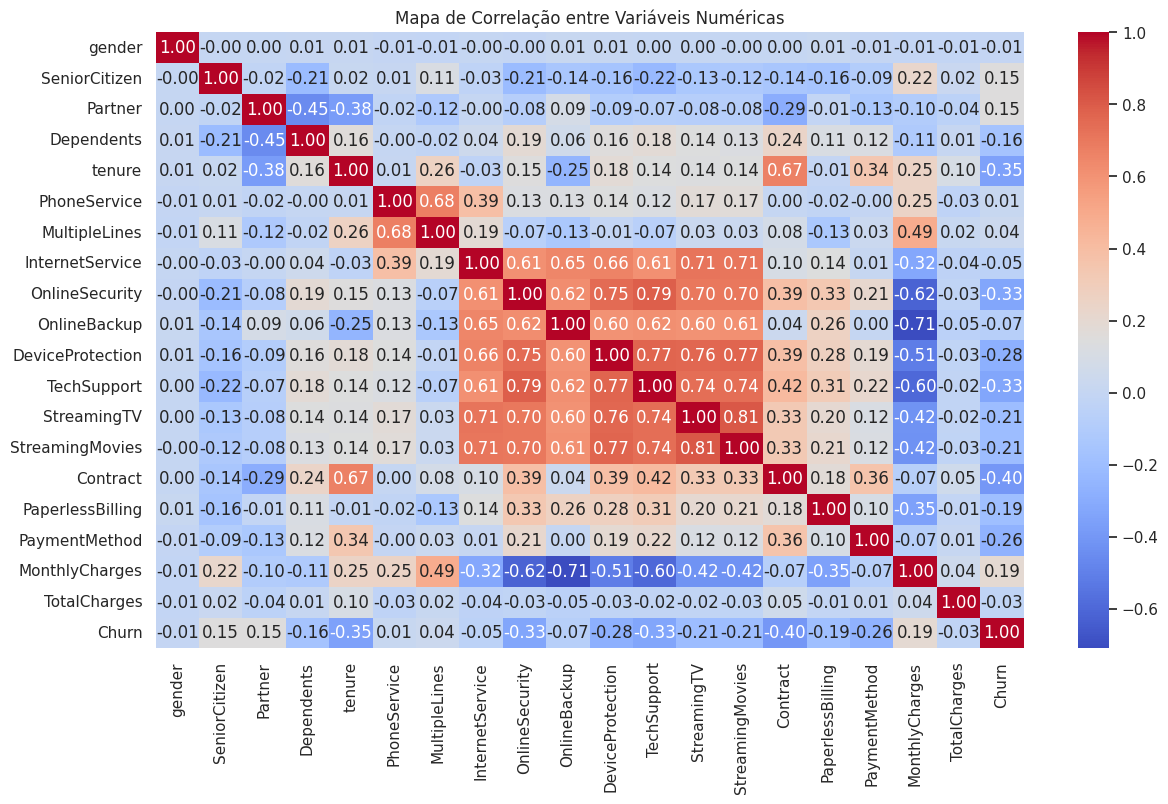

In [11]:
plt.figure(figsize=(14, 8))
sns.heatmap(df_numerical.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Mapa de Correla√ß√£o entre Vari√°veis Num√©ricas')
plt.show()

### Correla√ß√£o com a vari√°vel target

In [12]:
correlation_with_target = df_numerical.corr(numeric_only=True)['Churn'].sort_values(ascending=False)
correlation_with_target

Churn               1.000000
MonthlyCharges      0.193356
SeniorCitizen       0.150889
Partner             0.150448
MultipleLines       0.036310
PhoneService        0.011942
gender             -0.008612
TotalCharges       -0.027614
InternetService    -0.047291
OnlineBackup       -0.074205
Dependents         -0.164221
PaperlessBilling   -0.191825
StreamingTV        -0.205742
StreamingMovies    -0.207256
PaymentMethod      -0.262818
DeviceProtection   -0.281465
TechSupport        -0.329852
OnlineSecurity     -0.332819
tenure             -0.352229
Contract           -0.396713
Name: Churn, dtype: float64

## Insights da Correla√ß√£o

#### Correla√ß√µes positivas

In [13]:
correlacao_positiva = {
    'Vari√°vel': ['MonthlyCharges', 'SeniorCitizen', 'Partner', 'MultipleLines'],
    'Correla√ß√£o': [0.193, 0.151, 0.150, 0.036],
    'Insight': [
        'Mensalidades mais altas aumentam chance de churn',
        'Idosos t√™m maior propens√£o ao churn',
        'Clientes sem parceiro tendem a sair mais',
        'Uso de m√∫ltiplas linhas tem leve associa√ß√£o com churn'
    ]
}

pd.DataFrame(correlacao_positiva)

Vari√°vel  Correla√ß√£o  \
0  MonthlyCharges       0.193   
1   SeniorCitizen       0.151   
2         Partner       0.150   
3   MultipleLines       0.036   

                                             Insight  
0   Mensalidades mais altas aumentam chance de churn  
1                Idosos t√™m maior propens√£o ao churn  
2           Clientes sem parceiro tendem a sair mais  
3  Uso de m√∫ltiplas linhas tem leve associa√ß√£o co...

### Correla√ß√µes negativas

In [14]:
correlacao_negativa = {
    'Vari√°vel': ['Contract', 'tenure', 'OnlineSecurity', 'TechSupport',
                 'DeviceProtection', 'PaymentMethod', 'StreamingMovies', 'StreamingTV'],
    'Correla√ß√£o': [-0.397, -0.352, -0.333, -0.330, -0.281, -0.263, -0.207, -0.206],
    'Insight': [
        'Contratos longos reduzem churn',
        'Clientes antigos t√™m menor chance de churn',
        'Seguran√ßa online ajuda a reter clientes',
        'Suporte t√©cnico reduz o churn',
        'Prote√ß√£o de dispositivo est√° associada √† perman√™ncia',
        'Certas formas de pagamento ret√™m mais',
        'Uso de streaming de filmes ajuda a manter clientes',
        'Uso de streaming de TV ajuda a manter clientes'
    ]
}

pd.DataFrame(correlacao_negativa)

Vari√°vel  Correla√ß√£o  \
0          Contract      -0.397   
1            tenure      -0.352   
2    OnlineSecurity      -0.333   
3       TechSupport      -0.330   
4  DeviceProtection      -0.281   
5     PaymentMethod      -0.263   
6   StreamingMovies      -0.207   
7       StreamingTV      -0.206   

                                             Insight  
0                     Contratos longos reduzem churn  
1         Clientes antigos t√™m menor chance de churn  
2            Seguran√ßa online ajuda a reter clientes  
3                      Suporte t√©cnico reduz o churn  
4  Prote√ß√£o de dispositivo est√° associada √† perma...  
5              Certas formas de pagamento ret√™m mais  
6  Uso de streaming de filmes ajuda a manter clie...  
7     Uso de streaming de TV ajuda a manter clientes

### An√°lise por vari√°veis selecionadas

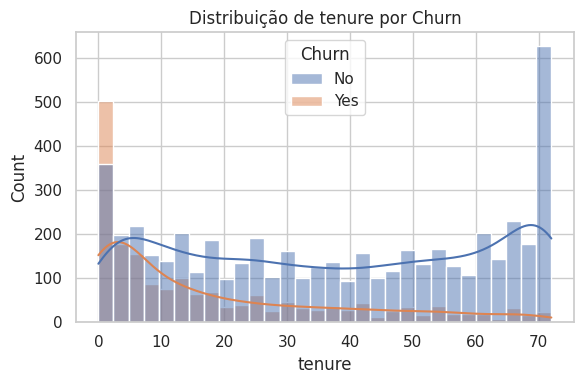

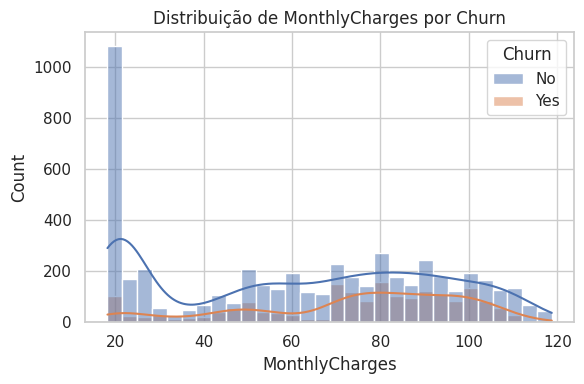

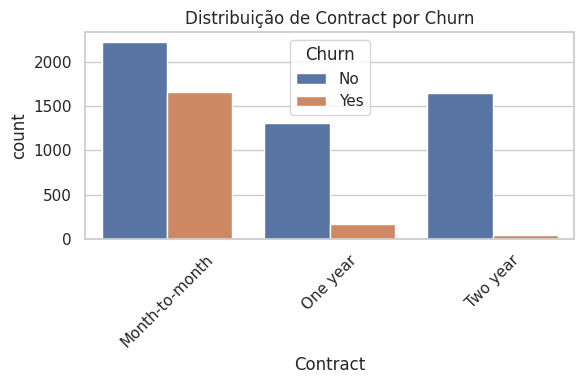

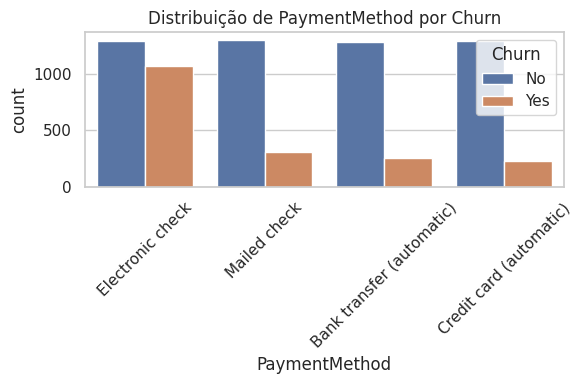

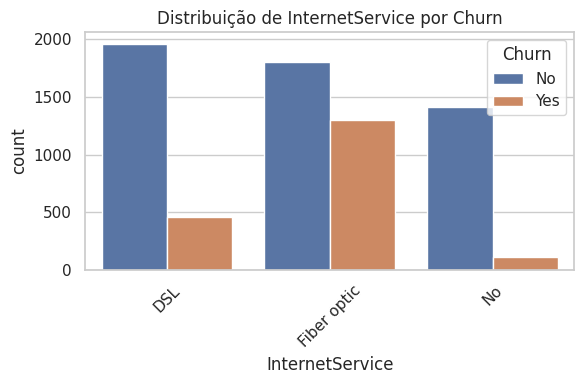

In [15]:
variaveis_para_analisar = ['tenure', 'MonthlyCharges', 'Contract', 'PaymentMethod', 'InternetService']

for var in variaveis_para_analisar:
    plt.figure(figsize=(6, 4))
    
    if df[var].dtype in ['int64', 'float64']:
        sns.histplot(data=df, x=var, hue='Churn', kde=True, bins=30)
    else:
        sns.countplot(data=df, x=var, hue='Churn')
        plt.xticks(rotation=45)
        
    plt.title(f'Distribui√ß√£o de {var} por Churn')
    plt.tight_layout()
    plt.show()

## Balanceamento com SMOTE

### Separando features e target

In [16]:
X = df_numerical[df_numerical.columns[0:-1]]
y = df_numerical[['Churn']]

### SMOTE + Split

In [17]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

### Antes do Balanceamento

In [18]:
y_train.value_counts()

Churn
0        4139
1        1495
Name: count, dtype: int64

### Depois do balanceamento

In [19]:
print(y_train_bal.value_counts())

Churn
0        4139
1        4139
Name: count, dtype: int64


## Treinamento e Avalia√ß√£o com Random Forest

### Modelo Random Forest

In [20]:
X = X_train_bal
y = y_train_bal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, np.array(y_train).ravel())

y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

### M√©tricas

In [21]:
print("Acur√°cia:", accuracy_score(y_test, y_pred))
print("Precis√£o:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nRelat√≥rio:\n", classification_report(y_test, y_pred))

Acur√°cia: 0.8349436392914654
Precis√£o: 0.8328
Recall: 0.8381642512077294
F1 Score: 0.8354735152487961

Relat√≥rio:
               precision    recall  f1-score   support

           0       0.84      0.83      0.83      1242
           1       0.83      0.84      0.84      1242

    accuracy                           0.83      2484
   macro avg       0.83      0.83      0.83      2484
weighted avg       0.83      0.83      0.83      2484



### Matriz de confus√£o

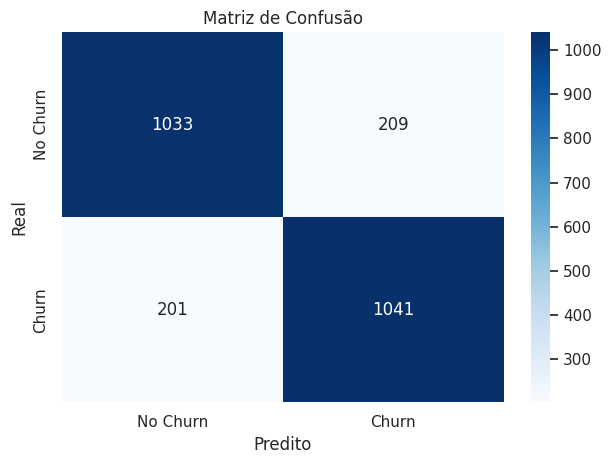

In [22]:

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Matriz de Confus√£o')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

### Curva Roc

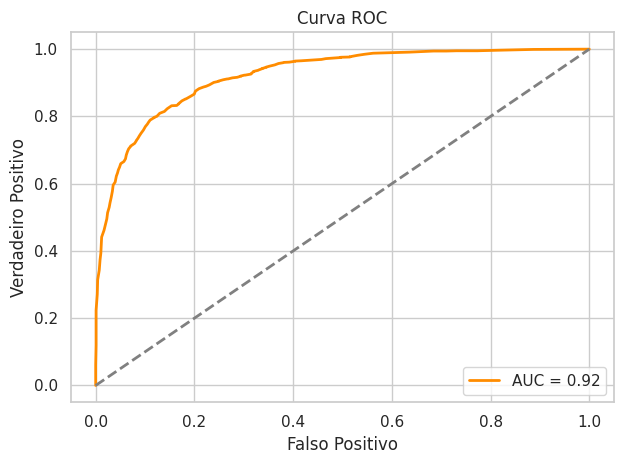

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## üìä Resultados

Ap√≥s o balanceamento da base de dados e o treinamento do modelo **Random Forest**, obtivemos os seguintes resultados na tarefa de **previs√£o de churn** (cancelamento de clientes):

- **Acur√°cia**: 83,49%  
- **Precis√£o**: 83,28%  
- **Recall**: 83,81%  
- **F1-Score**: 83,54%  
- **AUC (√Årea sob a curva ROC)**: 0,92

Esses indicadores demonstram que o modelo possui um desempenho consistente, com bom equil√≠brio entre identifica√ß√£o correta dos clientes que ir√£o cancelar (recall) e precis√£o nas previs√µes realizadas. O valor elevado de AUC refor√ßa a capacidade do modelo em diferenciar clientes propensos ao churn dos demais.

## ‚úÖ Conclus√µes

Os resultados indicam que o modelo treinado √© eficiente e confi√°vel para prever o **churn de clientes**, atingindo uma **AUC de 0,92**, o que representa uma excelente capacidade de discrimina√ß√£o entre os clientes que cancelam e os que permanecem.

### üîç Principais fatores associados ao churn:

- **Tipo de contrato**: Clientes com contratos **mensais** apresentam maior taxa de cancelamento.
- **Cobran√ßa mensal elevada**: Faturas mais altas aumentam significativamente a chance de churn.
- **Baixo tempo de fidelidade (tenure)**: Clientes mais recentes tendem a cancelar com maior frequ√™ncia.
- **Aus√™ncia de servi√ßos de suporte e seguran√ßa**: Falta de recursos como **TechSupport** e **OnlineSecurity** est√° associada a maiores taxas de cancelamento.

Essas informa√ß√µes s√£o extremamente valiosas para estrat√©gias de **reten√ß√£o**, como:

- Oferecer **benef√≠cios exclusivos** para clientes em risco.
- Criar **descontos direcionados**.
- Investir em **melhorias nos servi√ßos** mais associados √† insatisfa√ß√£o.

Com base nesses insights, √© poss√≠vel adotar uma abordagem proativa e personalizada, reduzindo o churn e aumentando o valor de vida do cliente (LTV).
